# Recreating https://arxiv.org/pdf/1608.02609.pdf first for $\rho$-$\rho$ decays

## Inputs:
- Invariant masses of intermediate resonances  
- Acoplanarity angles
- Variables $y_i^+$ ($y_k^-$)
- 4 momentum of visible decay products
- 4 momentum of intermediate resonances
    - If cascade decays, need to provide 4-momenta of all $\pi^+\pi^-$ pairs which can form the resonances
- Need to boost all four vectors where primary resonances are aligned along the z-axis.
- Normalise all features

## The setup

In [8]:
import uproot 
import numpy as np
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import os
import random

from pylorentz import Momentum4
from pylorentz import Position4
from lbn_modified import LBN, LBNLayer
from ROOT import TLorentzVector, TVector3

In [9]:
seed_value = 0
# 1. Set the PYTHONHASHSEED environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)
# 2. Set the python built-in pseudo-random generator at a fixed value
random.seed(seed_value)
# 3. Set the numpy pseudo-random generator at a fixed value
np.random.seed(seed_value)
# 4. Set the tensorflow pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(seed_value)

In [10]:
# some important options

# Which channel would you like to use?
CHANNEL = 'rho_rho'
#CHANNEL = 'rho_a1'
#CHANNEL = 'a1_a1'
# WARNING: IF YOU CHANGE CHANNEL, YOU HAVE TO RERUN THE WHOLE CODE FROM THE CHANNEL READ-IN!

# Which kind of labels do you want to use?
LABELS = 'continuous'
#LABELS = 'binary1'
#LABELS = 'binary2'
#WARNING: IF YOU CHANGE LABELS, YOU HAVE TO RERUN THE CREATE LABELS PART!

# Which kind of AUC would you like to use?
#AUC = 'unweighted'
AUC = 'weighted'
#WHEN YOU CHANGE AUC, YOU DON'T HAVE TO RERUN ANYTHING!

# The output filenames
FILENAME_OPTIONS = CHANNEL + '_' + LABELS + '_' + AUC

In [5]:
tree_tt = uproot.open("/eos/user/k/kgalambo/SWAN_projects/Masters_CP_Kristof_2/MVAFILE_AllHiggs_tt.root")["ntuple"]

variables = [
            "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand",
            "aco_angle_1",
            "aco_angle_5", "aco_angle_6", "aco_angle_7",
            "mva_dm_1","mva_dm_2",
            "tau_decay_mode_1","tau_decay_mode_2",
            "ip_x_1", "ip_y_1", "ip_z_1", "ip_x_2", "ip_y_2", "ip_z_2", # need impact parameter for aco_angle_6
            "pi_E_1", "pi_px_1", "pi_py_1", "pi_pz_1", # charged pion 1
            "pi_E_2", "pi_px_2", "pi_py_2", "pi_pz_2", # charged pion 2
            "pi0_E_1", "pi0_px_1", "pi0_py_1", "pi0_pz_1", # neutral pion 1
            "pi0_E_2", "pi0_px_2", "pi0_py_2", "pi0_pz_2", # neutral pion 2
            "y_1_1", "y_1_2" # y variables
        ]

In [6]:
# this line takes a long time!
df = tree_tt.pandas.df(variables)

In [11]:
if CHANNEL == 'rho_rho':
    # select only rho-rho events
    df_filtered = df[(df['mva_dm_1']==1) & (df['mva_dm_2']==1) & (df["tau_decay_mode_1"] == 1) & (df["tau_decay_mode_2"] == 1)]

elif CHANNEL == 'rho_a1':
    # select only rho-a1 events
    df_filtered = df[(df['mva_dm_1']==1) & (df['mva_dm_2']==10) & (df["tau_decay_mode_1"] == 1)]

elif CHANNEL == 'a1_a1':
    # select only a1-a1 events
    df_filtered = df[(df['mva_dm_1']==10) & (df['mva_dm_2']==10)]
    
else:
    print('CHANNEL not understood!')

In [12]:
# create labels y

# necessary for binary2 only:
df_filtered_ps = df_filtered[(df_filtered["rand"]<df_filtered["wt_cp_ps"]/2)]
df_filtered_sm = df_filtered[(df_filtered["rand"]<df_filtered["wt_cp_sm"]/2)]

if LABELS == 'continuous':
    # non-binary
    y = df_filtered["wt_cp_sm"] / (df_filtered["wt_cp_ps"] + df_filtered["wt_cp_sm"])

elif LABELS == 'binary1':
    # binary method 1
    y = (~(df_filtered["rand"]<df_filtered["wt_cp_ps"]/2).to_numpy()).astype(int)

elif LABELS == 'binary2':
    # binary method 2
    y_sm = pd.DataFrame(np.ones(df_filtered_sm.shape[0]))
    y_ps = pd.DataFrame(np.zeros(df_filtered_ps.shape[0]))
    y = pd.concat([y_sm, y_ps]).to_numpy()

else:
    print('LABELS not understood!')

In [13]:
w_a = df_filtered["wt_cp_sm"].to_numpy()
w_b = df_filtered["wt_cp_ps"].to_numpy()

## The particle data

In [14]:
# parse particle information
#columns = ['E', 'px', 'py', 'pz']

pi_1 = df_filtered[['pi_E_1', "pi_px_1", "pi_py_1", "pi_pz_1"]].to_numpy()
pi_2 = df_filtered[['pi_E_2', "pi_px_2", "pi_py_2", "pi_pz_2"]].to_numpy()
pi0_1 = df_filtered[['pi0_E_1', "pi0_px_1", "pi0_py_1", "pi0_pz_1"]].to_numpy()
pi0_2 = df_filtered[['pi0_E_2', "pi0_px_2", "pi0_py_2", "pi0_pz_2"]].to_numpy()

In [15]:
# reconstruct resonance 4 momentum
rho_1 = pi_1 + pi0_1
rho_2 = pi_2 + pi0_2

In [16]:
# calculate invariant masses
rho_1_m2 = rho_1[:, 0]**2 - rho_1[:, 1]**2 - rho_1[:, 2]**2 - rho_1[:, 3]**2
rho_2_m2 = rho_2[:, 0]**2 - rho_2[:, 1]**2 - rho_2[:, 2]**2 - rho_2[:, 3]**2

In [17]:
p3 = Momentum4(pi_1[:, 0], pi_1[:, 1], pi_1[:, 2], pi_1[:, 3]) # p3 = charged pion 1
p4 = Momentum4(pi_2[:, 0], pi_2[:, 1], pi_2[:, 2], pi_2[:, 3]) # p4 = charged pion 2
p1 = Momentum4(pi0_1[:, 0], pi0_1[:, 1], pi0_1[:, 2], pi0_1[:, 3]) # p1 = neutral pion 1
p2 = Momentum4(pi0_2[:, 0], pi0_2[:, 1], pi0_2[:, 2], pi0_2[:, 3]) # p2 = neutral pion 2
rest_frame = p1 + p2 + p3 + p4

In [18]:
p1_boosted = p1.boost_particle(-rest_frame)
p3_boosted = p3.boost_particle(-rest_frame)
p2_boosted = p2.boost_particle(-rest_frame)
p4_boosted = p4.boost_particle(-rest_frame)

r1_boosted = p1_boosted + p3_boosted
r2_boosted = p2_boosted + p4_boosted

## Calculation of other aco_angles

<font size=4 color='red'>__You can skip this part__</font>

In [13]:
y_1_1 = df_filtered['y_1_1'].to_numpy()
y_1_2 = df_filtered['y_1_2'].to_numpy()

In [20]:
def calc_aco(p1_boosted2, p2_boosted2, p3_boosted2, p4_boosted2, y_1=[], y_2=[]):
    """
    The input 4-vectors should be:
    Momentum4 instances with shape 4 by ?
    The energy (first) row doesn't matter, can be anything
    """
    
    if y_1 == [] or y_2 == []: # if no given y-s, then use the globally defined ones
        y_1 = y_1_1
        y_2 = y_1_2
        print('using default y-s')
    
    i = 0
    phi_cps = []
    def unit(vect):
        return vect / np.linalg.norm(vect)
    for pp1, pp2, pp3, pp4 in zip(p1_boosted2[:].T, p2_boosted2[:].T, p3_boosted2[:].T, p4_boosted2[:].T):
        n1 = pp1[1:] - np.dot(pp1[1:], unit(pp3[1:])) * unit(pp3[1:])
        n2 = pp2[1:] - np.dot(pp2[1:], unit(pp4[1:])) * unit(pp4[1:])
        n1 = unit(n1)
        n2 = unit(n2)

        angle = np.arccos(np.dot(n1, n2))
        sign = np.dot(unit(pp4[1:]), np.cross(n1, n2))

        # shift 1
        if sign < 0:
            angle = 2 * np.pi - angle
        
        # this part should be commented out
        if y_1[i] * y_2[i] < 0:
            if angle < np.pi:
                angle += np.pi
            else:
                angle -= np.pi
                
        phi_cps.append(angle)
        if i%100000==0:
            print('finished instance', i)
        i += 1
                
    return phi_cps

In [15]:
ip_1 = df_filtered[["ip_x_1", "ip_y_1", "ip_z_1"]].to_numpy()
ip_2 = df_filtered[["ip_x_2", "ip_y_2", "ip_z_2"]].to_numpy()
zeros = np.reshape(np.zeros(len(ip_1)), (-1, 1))
ip_1 = np.concatenate([zeros, ip_1], axis=1)
ip_2 = np.concatenate([zeros, ip_2], axis=1)

In [16]:
# calculate aco_angle_1
#phi_cps = calc_aco(p1_boosted, p2_boosted, p3_boosted, p4_boosted)

# calculate aco_angle_6
aco_6_calculated = calc_aco(ip_1.T, ip_2.T, p3_boosted, p4_boosted)

using default y-s
finished instance 0
finished instance 100000
finished instance 200000
finished instance 300000
finished instance 400000
finished instance 500000
finished instance 600000


## Compare calculated aco_angle_6-s

<font size=4 color='red'>__You can skip this part__</font>

In [18]:
# THIS IS UNBOOSTED, SO GIVES WRONG RESULTS

aco_angle_6_ps = df_filtered_ps['aco_angle_6'].to_numpy()
aco_angle_6_sm = df_filtered_sm['aco_angle_6'].to_numpy()

pi_1_ps = df_filtered_ps[['pi_E_1', "pi_px_1", "pi_py_1", "pi_pz_1"]].to_numpy()
pi_1_sm = df_filtered_sm[['pi_E_1', "pi_px_1", "pi_py_1", "pi_pz_1"]].to_numpy()
pi_2_ps = df_filtered_ps[['pi_E_2', "pi_px_2", "pi_py_2", "pi_pz_2"]].to_numpy()
pi_2_sm = df_filtered_sm[['pi_E_2', "pi_px_2", "pi_py_2", "pi_pz_2"]].to_numpy()
ip_1_ps = df_filtered_ps[["ip_x_1", "ip_y_1", "ip_z_1"]].to_numpy()
ip_1_sm = df_filtered_sm[["ip_x_1", "ip_y_1", "ip_z_1"]].to_numpy()
ip_2_ps = df_filtered_ps[["ip_x_2", "ip_y_2", "ip_z_2"]].to_numpy()
ip_2_sm = df_filtered_sm[["ip_x_2", "ip_y_2", "ip_z_2"]].to_numpy()
zeros_ps = np.reshape(np.zeros(len(ip_1_ps)), (-1, 1))
zeros_sm = np.reshape(np.zeros(len(ip_1_sm)), (-1, 1))
ip_1_ps = np.concatenate([zeros_ps, ip_1_ps], axis=1)
ip_1_sm = np.concatenate([zeros_sm, ip_1_sm], axis=1)
ip_2_ps = np.concatenate([zeros_ps, ip_2_ps], axis=1)
ip_2_sm = np.concatenate([zeros_sm, ip_2_sm], axis=1)

In [25]:
# THIS IS BOOSTED ACCORDING TO ALIE'S METHOD, GIVES ALMOST GOOD RESULTS

aco_angle_6_ps = df_filtered_ps['aco_angle_6'].to_numpy()
aco_angle_6_sm = df_filtered_sm['aco_angle_6'].to_numpy()

pi_1_ps = Momentum4(df_filtered_ps["pi_E_1"],df_filtered_ps["pi_px_1"],df_filtered_ps["pi_py_1"],df_filtered_ps["pi_pz_1"])
pi_1_sm = Momentum4(df_filtered_sm["pi_E_1"],df_filtered_sm["pi_px_1"],df_filtered_sm["pi_py_1"],df_filtered_sm["pi_pz_1"])
pi_2_ps = Momentum4(df_filtered_ps["pi_E_2"],df_filtered_ps["pi_px_2"],df_filtered_ps["pi_py_2"],df_filtered_ps["pi_pz_2"])
pi_2_sm = Momentum4(df_filtered_sm["pi_E_2"],df_filtered_sm["pi_px_2"],df_filtered_sm["pi_py_2"],df_filtered_sm["pi_pz_2"])
ip_1_ps = Momentum4(np.zeros(len(df_filtered_ps["ip_x_1"])),df_filtered_ps["ip_x_1"],df_filtered_ps["ip_y_1"],df_filtered_ps["ip_z_1"])
ip_1_sm = Momentum4(np.zeros(len(df_filtered_sm["ip_x_1"])),df_filtered_sm["ip_x_1"],df_filtered_sm["ip_y_1"],df_filtered_sm["ip_z_1"])
ip_2_ps = Momentum4(np.zeros(len(df_filtered_ps["ip_x_2"])),df_filtered_ps["ip_x_2"],df_filtered_ps["ip_y_2"],df_filtered_ps["ip_z_2"])
ip_2_sm = Momentum4(np.zeros(len(df_filtered_sm["ip_x_2"])),df_filtered_sm["ip_x_2"],df_filtered_sm["ip_y_2"],df_filtered_sm["ip_z_2"])

com_ps = Momentum4(pi_1_ps+pi_2_ps)
com_sm = Momentum4(pi_1_sm+pi_2_sm)
boost_ps = Momentum4(com_ps[0], -com_ps[1], -com_ps[2], -com_ps[3])
boost_sm = Momentum4(com_sm[0], -com_sm[1], -com_sm[2], -com_sm[3])
boost_ps = -com_ps
boost_sm = -com_sm
pi_1_ps = pi_1_ps.boost_particle(boost_ps)[:].T
pi_1_sm = pi_1_sm.boost_particle(boost_sm)[:].T
pi_2_ps = pi_2_ps.boost_particle(boost_ps)[:].T
pi_2_sm = pi_2_sm.boost_particle(boost_sm)[:].T
ip_1_ps = ip_1_ps.boost_particle(boost_ps)[:].T
ip_1_sm = ip_1_sm.boost_particle(boost_sm)[:].T
ip_2_ps = ip_2_ps.boost_particle(boost_ps)[:].T
ip_2_sm = ip_2_sm.boost_particle(boost_sm)[:].T

In [20]:
ip_1_ps.shape

(323769, 4)

In [21]:
# calculate aco_angle_6
aco_6_calculated_ps = calc_aco(ip_1_ps.T, ip_2_ps.T, pi_1_ps.T, pi_2_ps.T)
aco_6_calculated_sm = calc_aco(ip_1_sm.T, ip_2_sm.T, pi_1_sm.T, pi_2_sm.T)

finished instance 0
finished instance 100000
finished instance 200000
finished instance 300000
finished instance 0
finished instance 100000
finished instance 200000
finished instance 300000


In [15]:
# define function to plot 'signal' vs 'background' for a specified variables
# useful to check whether a variable gives some separation between
# signal and background states
def plot_signal_background(data1, data2, column,
                        bins=100, x_uplim=0, **kwargs):

    if "alpha" not in kwargs:
        kwargs["alpha"] = 0.5

    df1 = data1[column]
    df2 = data2[column]

    fig, ax = plt.subplots()
    #df1 = df1.sample(3000, random_state=1234)
    #df2 = df2.sample(3000, random_state=1234)
    #low = max(min(df1.min(), df2.min()),-5)
    low = 0
    #print(df1.min())
    #print(df2.min())
    high = max(df1.max(), df2.max())
    if x_uplim != 0: high = x_uplim

    ax.hist(df1, bins=bins, range=(low,high), **kwargs)
    ax.hist(df2, bins=bins, range=(low,high), **kwargs)
    if column == "aco_angle_6":
        plt.title('given aco_angle_6 (true values)')
    else:
        plt.title(column)
    
    if x_uplim != 0:
        ax.set_xlim(0,x_uplim)

    # ax.set_yscale('log')

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


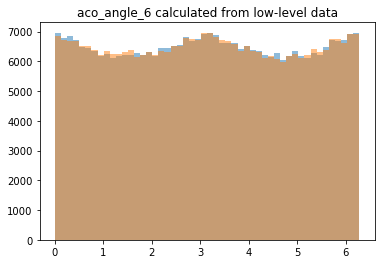

In [23]:
# plot my calculated aco_angle_6 values
aco_6_calculated_ps_df = pd.DataFrame(aco_6_calculated_ps, columns=['aco_angle_6 calculated from low-level data'])
aco_6_calculated_sm_df = pd.DataFrame(aco_6_calculated_sm, columns=['aco_angle_6 calculated from low-level data'])
plot_signal_background(aco_6_calculated_ps_df, aco_6_calculated_sm_df, 'aco_angle_6 calculated from low-level data', bins=50)

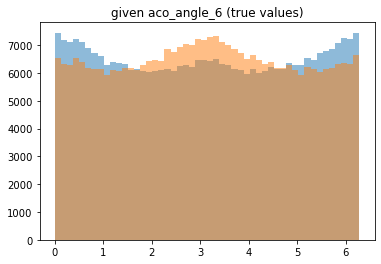

In [24]:
# plot the given aco_angle_6 values
aco_angle_6_ps_df = pd.DataFrame(aco_angle_6_ps, columns=['aco_angle_6'])
aco_angle_6_sm_df = pd.DataFrame(aco_angle_6_sm, columns=['aco_angle_6'])
plot_signal_background(aco_angle_6_ps_df, aco_angle_6_sm_df, 'aco_angle_6', bins=50)

# THIS ONLY WORKS FOR THE RHO-RHO CHANNEL I GUESS

In [25]:
#aco_6_calculated_merged = aco_6_calculated_ps_df.append(aco_6_calculated_sm_df, ignore_index=True)
#aco_angle_6_merged = aco_angle_6_ps_df.append(aco_angle_6_sm_df, ignore_index=True)
#plt.hist(aco_6_calculated_merged)

In [26]:
aco_6_calculated_merged = pd.concat([aco_6_calculated_ps_df, aco_6_calculated_sm_df], ignore_index=True)

In [27]:
aco_angle_6_merged = pd.concat([aco_angle_6_sm_df, aco_angle_6_ps_df], ignore_index=True)

Text(0.5, 1.0, 'calculated aco_angle_6 for the full dataset')

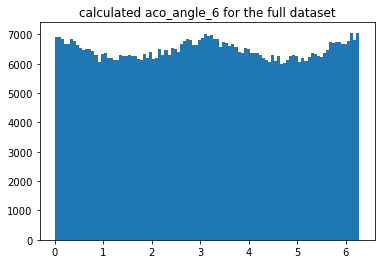

In [34]:
plt.hist(aco_6_calculated_merged.to_numpy(), bins=100, range=(0, 2*np.pi))
plt.title('calculated aco_angle_6 for the full dataset')

Text(0.5, 1.0, 'given aco_angle_6 for the full dataset (true values)')

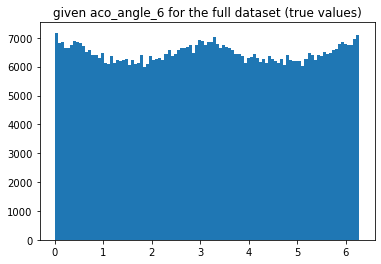

In [35]:
plt.hist(aco_angle_6_merged.to_numpy(), bins=100, range=(0, 2*np.pi))
plt.title('given aco_angle_6 for the full dataset (true values)')

## Check calculations on aco_angle_1

<font size=4 color='red'>__You can skip this part__</font>

In [26]:
aco_angle_1_ps = df_filtered_ps['aco_angle_1'].to_numpy()
aco_angle_1_sm = df_filtered_sm['aco_angle_1'].to_numpy()
y_1_ps = df_filtered_ps['y_1_1'].to_numpy()
y_1_sm = df_filtered_sm['y_1_2'].to_numpy()
y_2_ps = df_filtered_ps['y_1_1'].to_numpy()
y_2_sm = df_filtered_sm['y_1_2'].to_numpy()

pi_1_ps = Momentum4(df_filtered_ps["pi_E_1"],df_filtered_ps["pi_px_1"],df_filtered_ps["pi_py_1"],df_filtered_ps["pi_pz_1"])
pi_1_sm = Momentum4(df_filtered_sm["pi_E_1"],df_filtered_sm["pi_px_1"],df_filtered_sm["pi_py_1"],df_filtered_sm["pi_pz_1"])
pi_2_ps = Momentum4(df_filtered_ps["pi_E_2"],df_filtered_ps["pi_px_2"],df_filtered_ps["pi_py_2"],df_filtered_ps["pi_pz_2"])
pi_2_sm = Momentum4(df_filtered_sm["pi_E_2"],df_filtered_sm["pi_px_2"],df_filtered_sm["pi_py_2"],df_filtered_sm["pi_pz_2"])
pi0_1_ps = Momentum4(df_filtered_ps["pi0_E_1"],df_filtered_ps["pi0_px_1"],df_filtered_ps["pi0_py_1"],df_filtered_ps["pi0_pz_1"])
pi0_1_sm = Momentum4(df_filtered_sm["pi0_E_1"],df_filtered_sm["pi0_px_1"],df_filtered_sm["pi0_py_1"],df_filtered_sm["pi0_pz_1"])
pi0_2_ps = Momentum4(df_filtered_ps["pi0_E_2"],df_filtered_ps["pi0_px_2"],df_filtered_ps["pi0_py_2"],df_filtered_ps["pi0_pz_2"])
pi0_2_sm = Momentum4(df_filtered_sm["pi0_E_2"],df_filtered_sm["pi0_px_2"],df_filtered_sm["pi0_py_2"],df_filtered_sm["pi0_pz_2"])

com_ps = Momentum4(pi_1_ps+pi_2_ps)
com_sm = Momentum4(pi_1_sm+pi_2_sm)
boost_ps = Momentum4(com_ps[0], -com_ps[1], -com_ps[2], -com_ps[3])
boost_sm = Momentum4(com_sm[0], -com_sm[1], -com_sm[2], -com_sm[3])
boost_ps = -com_ps
boost_sm = -com_sm
pi_1_ps = pi_1_ps.boost_particle(boost_ps)[:].T
pi_1_sm = pi_1_sm.boost_particle(boost_sm)[:].T
pi_2_ps = pi_2_ps.boost_particle(boost_ps)[:].T
pi_2_sm = pi_2_sm.boost_particle(boost_sm)[:].T
pi0_1_ps = pi0_1_ps.boost_particle(boost_ps)[:].T
pi0_1_sm = pi0_1_sm.boost_particle(boost_sm)[:].T
pi0_2_ps = pi0_2_ps.boost_particle(boost_ps)[:].T
pi0_2_sm = pi0_2_sm.boost_particle(boost_sm)[:].T

In [22]:
y_1_ps.shape

(323769,)

In [23]:
# calculate aco_angle_6
aco_1_calculated_ps = calc_aco(pi0_1_ps.T, pi0_2_ps.T, pi_1_ps.T, pi_2_ps.T, y_1_ps, y_2_ps)
aco_1_calculated_sm = calc_aco(pi0_1_sm.T, pi0_2_sm.T, pi_1_sm.T, pi_2_sm.T, y_1_sm, y_2_sm)

finished instance 0


<ipython-input-20-1d0bcf5b2d7b>:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if y_1 == [] or y_2 == []: # if no given y-s, then use the globally defined ones


finished instance 100000
finished instance 200000
finished instance 300000
finished instance 0
finished instance 100000
finished instance 200000
finished instance 300000


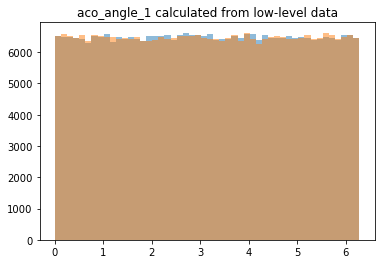

In [24]:
# plot my calculated aco_angle_6 values
aco_1_calculated_ps_df = pd.DataFrame(aco_1_calculated_ps, columns=['aco_angle_1 calculated from low-level data'])
aco_1_calculated_sm_df = pd.DataFrame(aco_1_calculated_sm, columns=['aco_angle_1 calculated from low-level data'])
plot_signal_background(aco_1_calculated_ps_df, aco_1_calculated_sm_df, 'aco_angle_1 calculated from low-level data', bins=50)

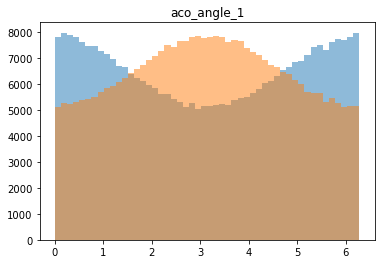

In [39]:
# plot the given aco_angle_6 values
aco_angle_1_ps_df = pd.DataFrame(aco_angle_1_ps, columns=['aco_angle_1'])
aco_angle_1_sm_df = pd.DataFrame(aco_angle_1_sm, columns=['aco_angle_1'])
plot_signal_background(aco_angle_1_ps_df, aco_angle_1_sm_df, 'aco_angle_1', bins=50)

# THIS ONLY WORKS FOR THE RHO-RHO CHANNEL I GUESS

## Trying some calculation of other aco_angles

<font size=4 color='red'>__You can skip this part__</font>

In [51]:
aco_5_calculated_ps = calc_aco(pi_1_ps.T, pi_2_ps.T, ip_1_ps.T, ip_2_ps.T, y_1_ps, y_2_ps)

<ipython-input-20-1d0bcf5b2d7b>:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if y_1 == [] or y_2 == []: # if no given y-s, then use the globally defined ones


finished instance 0
finished instance 100000
finished instance 200000
finished instance 300000


Text(0.5, 1.0, 'calculated aco_angle_5')

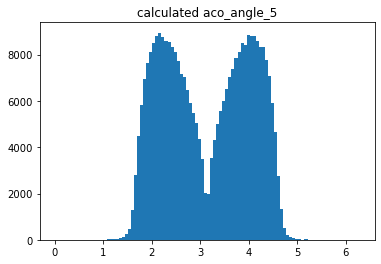

In [52]:
plt.hist(np.array(aco_5_calculated_ps), bins=100, range=(0, 2*np.pi))
plt.title('calculated aco_angle_5')

In [39]:
aco_5_calculated_sm = calc_aco(pi0_1_sm.T, ip_1_sm.T, pi_1_sm.T, pi_2_sm.T, y_1_sm, y_2_sm)

<ipython-input-20-1d0bcf5b2d7b>:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if y_1 == [] or y_2 == []: # if no given y-s, then use the globally defined ones


finished instance 0
finished instance 100000
finished instance 200000
finished instance 300000


Text(0.5, 1.0, 'calculated aco_angle_5')

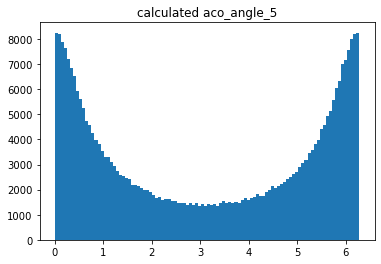

In [40]:
plt.hist(np.array(aco_5_calculated_sm), bins=100, range=(0, 2*np.pi))
plt.title('calculated aco_angle_5')

## Rotations

In [19]:
# unit vectors along the momenta of the primary resonances
unit1 = (r1_boosted[1:, :] / np.linalg.norm(r1_boosted[1:, :], axis=0)).transpose()
unit2 = (r2_boosted[1:, :] / np.linalg.norm(r2_boosted[1:, :], axis=0)).transpose()

# probably there's a faster way of doing this
zaxis = np.array([np.array([0., 0., 1.]) for _ in range(len(unit1))])

axes1 = np.cross(unit1, zaxis)
axes2 = np.cross(unit2, zaxis)

dotproduct1 = (unit1*zaxis).sum(1)
angles1 = np.arccos(dotproduct1)
dotproduct2 = (unit2*zaxis).sum(1)
angles2 = np.arccos(dotproduct2)

In [20]:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.dot(axis, axis)**0.5
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def rotate(vect, axis, theta):
    return np.dot(rotation_matrix(axis, theta), vect)

test_vector = [1, 0, 0]
test_axis = [0, 1, 0]
test_angle = np.pi/2

print('The rotated test_vector is:')
print(rotate(test_vector, test_axis, test_angle))

The rotated test_vector is:
[ 2.22044605e-16  0.00000000e+00 -1.00000000e+00]


In [21]:
# it would be nice to be able to do the rotation in a vectorized form, like this:
#p1rot = rotate(p1_boosted[1:, :].transpose(), axes1, angles1)

p1rot = []
p2rot = []
p3rot = []
p4rot = []
for i in range(p1_boosted[:].shape[1]):
    p1rot.append(rotate(p1_boosted[1:, i], axes1[i], angles1[i]))
    p2rot.append(rotate(p2_boosted[1:, i], axes1[i], angles1[i]))
    p3rot.append(rotate(p3_boosted[1:, i], axes1[i], angles1[i]))
    p4rot.append(rotate(p4_boosted[1:, i], axes1[i], angles1[i]))
    if i%100000==0:
        print('finished rotating 3-vector', i)
p1rot = np.array(p1rot)
p2rot = np.array(p2rot)
p3rot = np.array(p3rot)
p4rot = np.array(p4rot)

finished rotating 3-vector 0
finished rotating 3-vector 100000
finished rotating 3-vector 200000
finished rotating 3-vector 300000
finished rotating 3-vector 400000
finished rotating 3-vector 500000
finished rotating 3-vector 600000


In [22]:
# this should be vectorized as well
p1_rotated = []
p2_rotated = []
p3_rotated = []
p4_rotated = []
for i in range(p1_boosted[:].shape[1]):
    p1_rotated.append([p1_boosted[0, i], p1rot[i, 0], p1rot[i, 1], p1rot[i, 2]])
    p2_rotated.append([p2_boosted[0, i], p2rot[i, 0], p2rot[i, 1], p2rot[i, 2]])
    p3_rotated.append([p3_boosted[0, i], p3rot[i, 0], p3rot[i, 1], p3rot[i, 2]])
    p4_rotated.append([p4_boosted[0, i], p4rot[i, 0], p4rot[i, 1], p4rot[i, 2]])
    if i%100000==0:
        print('finished getting rotated 4-vector', i)
p1_rotated = np.array(p1_rotated).transpose()
p2_rotated = np.array(p2_rotated).transpose()
p3_rotated = np.array(p3_rotated).transpose()
p4_rotated = np.array(p4_rotated).transpose()

finished getting rotated 4-vector 0
finished getting rotated 4-vector 100000
finished getting rotated 4-vector 200000
finished getting rotated 4-vector 300000
finished getting rotated 4-vector 400000
finished getting rotated 4-vector 500000
finished getting rotated 4-vector 600000


## The neural net

In [23]:
# create features and labels

aco_angle_1 = df_filtered['aco_angle_1'].to_numpy()
y_1_1 = df_filtered['y_1_1'].to_numpy()
y_1_2 = df_filtered['y_1_2'].to_numpy()

aco_angle_5 = df_filtered['aco_angle_5'].to_numpy()
aco_angle_6 = df_filtered['aco_angle_6'].to_numpy()
aco_angle_7 = df_filtered['aco_angle_7'].to_numpy()

# this will use the unrotated, boosted 4-vectors:
E1 = p1_boosted[0]
px1 = p1_boosted[1]
py1 = p1_boosted[2]
pz1 = p1_boosted[3]
E2 = p2_boosted[0]
px2 = p2_boosted[1]
py2 = p2_boosted[2]
pz2 = p2_boosted[3]
E3 = p3_boosted[0]
px3 = p3_boosted[1]
py3 = p3_boosted[2]
pz3 = p3_boosted[3]
E4 = p4_boosted[0]
px4 = p4_boosted[1]
py4 = p4_boosted[2]
pz4 = p4_boosted[3]

# this will use the rotated, boosted 4-vectors:
E1r = p1_rotated[0]
px1r = p1_rotated[1]
py1r = p1_rotated[2]
pz1r = p1_rotated[3]
E2r = p2_rotated[0]
px2r = p2_rotated[1]
py2r = p2_rotated[2]
pz2r = p2_rotated[3]
E3r = p3_rotated[0]
px3r = p3_rotated[1]
py3r = p3_rotated[2]
pz3r = p3_rotated[3]
E4r = p4_rotated[0]
px4r = p4_rotated[1]
py4r = p4_rotated[2]
pz4r = p4_rotated[3]

# y is defined earlier

In [24]:
other_aco_angles_added = False

In [25]:
def filter_nans(X, y, config_num=-1):
    # this would remove the nans from the feature and the label set
    nan_mask = np.array([x.any() for x in np.isnan(X)])
    nan_mask_y = np.array([x.any() for x in nan_mask])
    #print((nan_mask_y == nan_mask).all())
    #print(nan_mask_y.shape)
    #print(y.shape)
    #print(X.shape)
              
    new_shape = 21
    if config_num == 1:
        new_shape = 1
    if config_num == 2:
        new_shape = 3
    if config_num == 3:
        new_shape = 16
    if config_num == 4:
        new_shape = 17
    if config_num == 5:
        new_shape = 5
    if config_num == 6:
        new_shape = 21
        
    if CHANNEL == 'rho_a1' and other_aco_angles_added:
        if config_num == 1:
            new_shape = 4
        if config_num == 2:
            new_shape = 6
        if config_num == 3:
            new_shape = 16
        if config_num == 4:
            new_shape = 20
        if config_num == 5:
            new_shape = 8
        if config_num == 6:
            new_shape = 24
                
    X = X[~nan_mask].reshape((-1, new_shape))
    y = y[~nan_mask_y]
    #print(X.shape)
    #print(y.shape)
    return X, y

In [26]:
def filter_nans(X, y, w_a, w_b, config_num=-1):
    # this would remove the nans from the feature and the label set
    nan_mask = np.array([x.any() for x in np.isnan(X)])
    nan_mask_y = np.array([x.any() for x in nan_mask])
    #print((nan_mask_y == nan_mask).all())
    #print(nan_mask_y.shape)
    #print(y.shape)
    #print(X.shape)
              
    new_shape = 21
    if config_num == 1:
        new_shape = 1
    if config_num == 2:
        new_shape = 3
    if config_num == 3:
        new_shape = 16
    if config_num == 4:
        new_shape = 17
    if config_num == 5:
        new_shape = 5
    if config_num == 6:
        new_shape = 21
        
    if CHANNEL == 'rho_a1' and other_aco_angles_added:
        if config_num == 1:
            new_shape = 4
        if config_num == 2:
            new_shape = 6
        if config_num == 3:
            new_shape = 16
        if config_num == 4:
            new_shape = 20
        if config_num == 5:
            new_shape = 8
        if config_num == 6:
            new_shape = 24
                
    X = X[~nan_mask].reshape((-1, new_shape))
    y = y[~nan_mask_y]
    w_a = w_a[~nan_mask_y]
    w_b = w_b[~nan_mask_y]
    #print(X.shape)
    #print(y.shape)
    return X, y, w_a, w_b

In [27]:
# define a simple NN
def baseline_model2(dimensions=-1):
    if dimensions == -1:
        dimensions = X.shape[1]
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(38, input_dim=dimensions, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam')  
    return model

def baseline_model(dimensions=-1):
    if dimensions == -1:
        dimensions = X.shape[1]
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(300, input_dim=dimensions, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(300, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam')  
    return model

In [28]:
#  define a function to plot the ROC curves - just makes the roc_curve look nicer than the default
def plot_roc_curve(fpr, tpr, auc, filename='roc_untitled'):
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.plot(fpr, tpr)
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.grid()
    ax.text(0.6, 0.3, 'ROC AUC Score: {:.3f}'.format(auc),
            bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='k'))
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, 'k--')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.savefig('paper/' + filename)
    plt.close()

In [29]:
def load_config(i):
    if i==1:
        X = np.reshape(aco_angle_1, (-1, 1))
        #print('SHAPE:')
        #print(X.shape)
    if i==2:
        X = np.stack([aco_angle_1, y_1_1, y_1_2], axis=1)
        #print('SHAPE:')
        #print(X.shape)
    if i==3:
        X = np.stack([E1r, px1r, py1r, pz1r, E2r, px2r, py2r, pz2r, E3r, px3r, py3r, pz3r, E4r, px4r, py4r, pz4r], axis=1)
    if i==4:
        X = np.stack([aco_angle_1, E1r, px1r, py1r, pz1r, E2r, px2r, py2r, pz2r, E3r, px3r, py3r, pz3r, E4r, px4r, py4r, pz4r], axis=1)
    if i==5:
        X = np.stack([rho_1_m2, rho_2_m2, aco_angle_1, y_1_1, y_1_2], axis=1)
    if i==6:
        X = np.stack([rho_1_m2, rho_2_m2, E1r, px1r, py1r, pz1r, E2r, px2r, py2r, pz2r, E3r, px3r, py3r, pz3r, E4r, px4r, py4r, pz4r, aco_angle_1, y_1_1, y_1_2], axis=1)

    if CHANNEL == 'rho_a1' and other_aco_angles_added:
        if i==1:
            X = np.stack([aco_angle_1, aco_angle_5, aco_angle_6, aco_angle_7], axis=1)
        if i==2:
            X = np.stack([aco_angle_1, aco_angle_5, aco_angle_6, aco_angle_7, y_1_1, y_1_2], axis=1)
        if i==3:
            X = np.stack([E1r, px1r, py1r, pz1r, E2r, px2r, py2r, pz2r, E3r, px3r, py3r, pz3r, E4r, px4r, py4r, pz4r], axis=1)
        if i==4:
            X = np.stack([aco_angle_1, aco_angle_5, aco_angle_6, aco_angle_7, E1r, px1r, py1r, pz1r, E2r, px2r, py2r, pz2r, E3r, px3r, py3r, pz3r, E4r, px4r, py4r, pz4r], axis=1)
        if i==5:
            X = np.stack([rho_1_m2, rho_2_m2, aco_angle_1, aco_angle_5, aco_angle_6, aco_angle_7, y_1_1, y_1_2], axis=1)
        if i==6:
            X = np.stack([rho_1_m2, rho_2_m2, E1r, px1r, py1r, pz1r, E2r, px2r, py2r, pz2r, E3r, px3r, py3r, pz3r, E4r, px4r, py4r, pz4r, aco_angle_1, aco_angle_5, aco_angle_6, aco_angle_7, y_1_1, y_1_2], axis=1)
        
        
    return X

def run_config(config_num, y, w_a, w_b, epoch_number, batch_number):
    X = load_config(config_num)

    want_filter_nans = False
    if CHANNEL == 'rho_a1' or CHANNEL == 'a1_a1':
        want_filter_nans = True
    if want_filter_nans:
        X, y, w_a, w_b = filter_nans(X, y, w_a, w_b, config_num)
        
    w_a_train, w_a_test, w_b_train, w_b_test  = train_test_split(w_a, w_b, test_size=0.2, random_state=123456)
    
    # split X and y into train and validation dataset 

    #print(X.shape)
    #print(y.shape)
    
    X_train, X_test, y_train, y_test  = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=123456,
        #stratify=y.values,
    )
    
    # define early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    # first run the training for simple case with just 1 variable
    history = tf.keras.callbacks.History()

    model = baseline_model(X.shape[1])

    model.fit(
                    X_train, y_train,
                    batch_size=batch_number,
                    epochs=epoch_number,
                    callbacks=[history,early_stop],
                    validation_data=(X_test, y_test))
    
    # Extract number of run epochs from the training history
    epochs = range(1, len(history.history["loss"])+1)

    # Extract loss on training and validation ddataset and plot them together
    plt.figure(2)
    plt.plot(epochs, history.history["loss"], "o-", label="Training")
    plt.plot(epochs, history.history["val_loss"], "o-", label="Test")
    plt.xlabel("Epochs"), plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend()
    plt.savefig('paper/history_' + FILENAME_OPTIONS + '_config' + str(config_num))
    plt.close()
    
    prediction = model.predict(X_test)
    
    # plot ROC curve for improved training
    y_proba = model.predict_proba(X_test) # outputs two probabilties
    
    def stanley_auc():
        #Stanley's way of calculating auc
        y_pred_roc = model.predict(X_test) #for test dataset
        #y_pred_roc = model.predict(X) # for full dataset
        y_pred_roc_final = np.r_[y_pred_roc, y_pred_roc]
        set_a = np.ones(len(y_pred_roc))
        set_b = np.zeros(len(y_pred_roc))
        y_label_roc = np.r_[set_a, set_b]
        w_roc = np.r_[w_a_test, w_b_test] # for test dataset
        #w_roc = np.r_[w_a, w_b] # for full dataset
        #print('========================================')
        #print(y_label_roc.shape)
        #print(y_pred_roc_final.shape)
        #print(w_roc.shape)
        #print('========================================')
        auc = roc_auc_score(y_label_roc, y_pred_roc_final, sample_weight=w_roc)
        return auc
    
    if LABELS == 'continuous':
        # the original way of calculating auc
        y_binary = (y_test > 0.5) * 1.0
        if AUC == 'unweighted':
            auc = roc_auc_score(y_binary, y_proba)
        if AUC == 'weighted':
            auc = stanley_auc()
        fpr, tpr, _ = roc_curve(y_binary, y_proba)
        
    if LABELS == 'binary1' or LABELS == 'binary2':
        if AUC == 'unweighted':
            auc = roc_auc_score(y_test, y_proba)
        if AUC == 'weighted':
            auc = stanley_auc()
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        
    plot_roc_curve(fpr, tpr, auc, 'roc_' + FILENAME_OPTIONS + '_config' + str(config_num))
    
    f = open('paper/auc_' + FILENAME_OPTIONS + '.txt', 'a')
    f.write(str(config_num) + ',' + str(auc) + '\n')
    f.close()

In [30]:
def run_experiments(exp_no, epoch_no=50, batch_no=1000):
    confs = [1, 2, 3, 4, 5, 6]
    for i in range(exp_no):
        for conf in confs:
            run_config(conf, y, w_a.copy(), w_b.copy(), epoch_no, batch_no)
            print('CONFIG', conf, 'DONE')
        print()
        print()
        print()
        print('##########################################################')
        print('DONE ITERATION', i)
        print('##########################################################')
        print()
        print()
        print()

In [31]:
# run 8 experiments
#run_experiments(8)

run_experiments(1, 30)

Epoch 1/30
523/523 [==============================] - 12s 22ms/step - loss: 0.6821 - val_loss: 0.6803
Epoch 2/30
523/523 [==============================] - 11s 21ms/step - loss: 0.6804 - val_loss: 0.6803
Epoch 3/30
523/523 [==============================] - 11s 22ms/step - loss: 0.6804 - val_loss: 0.6803
Epoch 4/30
523/523 [==============================] - 11s 21ms/step - loss: 0.6804 - val_loss: 0.6803
Epoch 5/30
523/523 [==============================] - 11s 22ms/step - loss: 0.6803 - val_loss: 0.6803
Epoch 6/30
523/523 [==============================] - 11s 21ms/step - loss: 0.6803 - val_loss: 0.6803
Epoch 7/30
523/523 [==============================] - 11s 21ms/step - loss: 0.6804 - val_loss: 0.6803
Epoch 8/30
523/523 [==============================] - 11s 21ms/step - loss: 0.6803 - val_loss: 0.6803
Epoch 9/30
523/523 [==============================] - 12s 22ms/step - loss: 0.6803 - val_loss: 0.6806
Epoch 10/30
523/523 [==============================] - 12s 24ms/step - loss: 0.680

W1204 12:30:44.684738 139776051185472 deprecation.py:317] From <ipython-input-29-b2fe2557ed64>:91: Sequential.predict_proba (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use `model.predict()` instead.


CONFIG 1 DONE
Epoch 1/30
523/523 [==============================] - 12s 23ms/step - loss: 0.6811 - val_loss: 0.6793
Epoch 2/30
523/523 [==============================] - 12s 23ms/step - loss: 0.6785 - val_loss: 0.6779
Epoch 3/30
523/523 [==============================] - 12s 23ms/step - loss: 0.6778 - val_loss: 0.6773
Epoch 4/30
523/523 [==============================] - 12s 23ms/step - loss: 0.6774 - val_loss: 0.6777
Epoch 5/30
523/523 [==============================] - 12s 23ms/step - loss: 0.6773 - val_loss: 0.6775
Epoch 6/30
523/523 [==============================] - 12s 22ms/step - loss: 0.6771 - val_loss: 0.6770
Epoch 7/30
523/523 [==============================] - 12s 24ms/step - loss: 0.6771 - val_loss: 0.6774
Epoch 8/30
523/523 [==============================] - 12s 23ms/step - loss: 0.6770 - val_loss: 0.6770
Epoch 9/30
523/523 [==============================] - 12s 24ms/step - loss: 0.6770 - val_loss: 0.6771
Epoch 10/30
523/523 [==============================] - 11s 21ms/step

2020-12-04 12:24:47.486541: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-12-04 12:24:47.510494: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2400135000 Hz
2020-12-04 12:24:47.512059: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x16ca0970 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-12-04 12:24:47.512097: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
